---
title: "Anomaly/Outlier Detection: Country Data"
author: "Julia Chen"
date: "2023-11-29"
categories: []
image: "image.png"
---

In this blog post, I will demonstate anomaly/outlier detection using country data (e.g. information on health, economics, etc). I'll be using DBSCAN to find anomalies that lie outside clusters.

## Preparing the Data

First, let's read in the country data from the csv file.

In [5]:
import pandas as pd

dataset = pd.read_csv("country_data/Country-data.csv")
dataset

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


Here are the descriptions of each field.

In [6]:
pd.read_csv("country_data/data-dictionary.csv")

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


And more information on our country dataset:

In [7]:
dataset.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [9]:
dataset.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Using DBSCAN to Find Anomalies

Let's import some libraries that we'll need:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Let's use some of the fields as our x values and scale them.

In [11]:
x_data = dataset[['total_fer', 'imports', 'gdpp']]
x_data = StandardScaler().fit_transform(x_data)

x_data

array([[ 1.90288227e+00, -8.24549559e-02, -6.79179609e-01],
       [-8.59972814e-01,  7.08366942e-02, -4.85623236e-01],
       [-3.84043958e-02, -6.41762328e-01, -4.65375609e-01],
       [ 2.12815103e+00, -1.65315307e-01, -5.16268293e-01],
       [-5.41946330e-01,  4.97567504e-01, -4.18171341e-02],
       [-3.82933087e-01, -1.27978703e+00, -1.45791437e-01],
       [-8.33470607e-01, -6.58828857e-02, -5.33232522e-01],
       [-6.74457365e-01, -1.07677917e+00,  2.13069856e+00],
       [-9.99109401e-01,  3.76925537e-02,  1.85708197e+00],
       [-6.81082917e-01, -1.08506521e+00, -3.89857431e-01],
       [-7.20836227e-01, -1.32171167e-01,  8.22811276e-01],
       [-5.22069674e-01,  1.66126098e-01,  4.23331061e-01],
       [-4.09435294e-01, -1.03949202e+00, -6.67961329e-01],
       [-7.73840641e-01,  7.49797118e-02,  1.66131471e-01],
       [-9.65981642e-01,  7.29576488e-01, -3.79460001e-01],
       [-7.20836227e-01,  1.15216428e+00,  1.72027368e+00],
       [-1.57664328e-01,  4.39565258e-01

Now, let's apply DBSCAN clustering to find the clusters and anomalies.

In [12]:
db = DBSCAN(eps=0.42, min_samples=7).fit(x_data)

anomaly_count = list(db.labels_).count(-1)
cluster_count = len(set(db.labels_)) - (1 if anomaly_count > 0 else 0)

print("Number of clusters = %d" % cluster_count)
print("Number of anomalies = %d" % anomaly_count)


Estimated number of clusters: 3
Estimated number of noise points: 71


This function is used to plot the DBSCAN results on a scatterplot [from: handson-ml3 unsupervised learning].

In [13]:
## Taken from handson-ml3 unsupervised learning
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=50)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

Now, let's use the function above to plot our DBSCAN results.

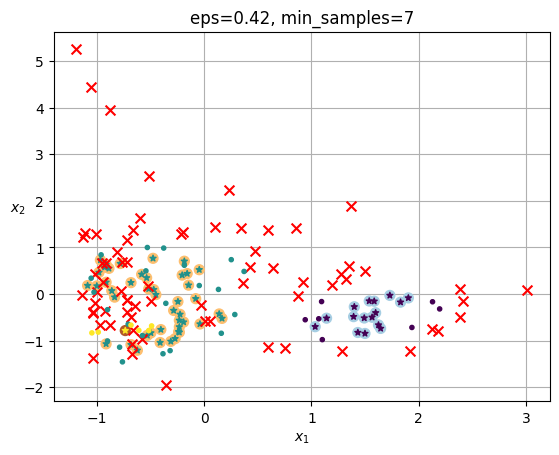

In [14]:
plot_dbscan(db, x_data, size=50)

We can see the anomalies shown in the plot (marked with an X).

Now, let's print the anomalies in a table format.

In [15]:
print("Anomalies:")

dataset[db.labels_ == -1]

Anomalies:


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000
...,...,...,...,...,...,...,...,...,...,...
155,Uganda,81.0,17.1,9.01,28.6,1540,10.600,56.8,6.15,595
157,United Arab Emirates,8.6,77.7,3.66,63.6,57600,12.500,76.5,1.87,35000
159,United States,7.3,12.4,17.90,15.8,49400,1.220,78.7,1.93,48400
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.620,63.0,3.50,2970


## Resources

https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data

https://github.com/maptv/handson-ml3/blob/main/09_unsupervised_learning.ipynb

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

https://www.kaggle.com/code/aditiani/kmeans-clustering-and-dbscan-for-country-data#Define-Clustering-Target

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

https://www.kaggle.com/code/tanmay111999/clustering-pca-k-means-dbscan-hierarchical#Modeling

https://www.kaggle.com/code/chandrimad31/clustering-with-pca-kmeans-hierarchical-dbscan#(4)-DBSCAN-Clustering

https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

https://commons.wikimedia.org/wiki/File:Physical_Map_of_the_World_(2021).svg



